In [1]:
# Performs PCA on the stars of a dataset and saves it into a new dataset containing only the necessary variables for classification
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset 
data_path = '/Users/ec270266/Documents/Phd/Euclid/dev/output/psf_dataset/'
test_dataset = np.load(data_path + 'test_Euclid_res_20000_TestStars_id_002GT_100_bins.npy', allow_pickle=True)[()]
train_dataset = np.load(data_path + 'train_Euclid_res_52000_TrainStars_id_002GT_100_bins.npy', allow_pickle=True)[()]
output_path = data_path

In [3]:
# Load the stars

noiseless_train_stars = train_dataset['stars']
noiseless_test_stars = test_dataset['stars']
noisy_train_stars = train_dataset['noisy_stars']
noisy_test_stars = test_dataset['noisy_stars']

In [4]:
def perform_PCA(N_components, fit_selection, *transform_selection):
    """Performs PCA decomposition on star sets and returns a PCA star sets.

    Args:
        N_components (int): Number of PCA components to do the analysis.
        fit_selection: Star set (in 32x32 float array format) to do the PCA fit.
        transform_selection: Variable amount of star sets to do the PCA transform on.
        
    Returns: 
        List: Processed PCA star sets.
    """
    pca = PCA(n_components= N_components) 
    pca.fit(fit_selection.reshape(-1, 1024))

    pca_processed_sets = []
    for i in range(len(transform_selection)):
        pca_processed_sets.append(pca.transform(transform_selection[i].reshape(-1, 1024)))

    return pca_processed_sets



In [5]:
def SEDlisttoC(SED_list):
    sed_array = np.array(SED_list)
    return sed_array*0.5 + 1.5

### Different ways of doing PCA
- A: fit and transform both noiseless train and test sets 
- B: fit and transform both noisy train and test sets
- C: fit noiseless train and test sets, transform noisy train and test sets
- D: fit and transform both noisy train and test sets with SNR >= 50
- E: fit and transform noisy train set, fit and transform noisy test set

The chosen method was B.

In [6]:
# Dataset B

fit_selection = np.concatenate((noisy_train_stars, noisy_test_stars), axis = 0)
#PCA_components = [12, 15, 18, 21, 24, 27, 30, 33]
PCA_components = [24, 30]
train_size=len(train_dataset['noisy_stars'])

for N_components in PCA_components:
   
    train_only_stars = False
    
    if train_only_stars:
        fit_selection = train_dataset['noisy_stars']
        X, = perform_PCA(N_components, fit_selection, train_dataset['noisy_stars'])
        Y = SEDlisttoC(train_dataset['SED_ids'])
        Z = train_dataset['SED_ids']
        x_train, x_test, y_train, y_test, sed_train, sed_test = train_test_split(X, Y, Z, test_size = int(train_size/2.6), shuffle = False) # Reserve stars for test
        x_train, x_val, y_train, y_val, sed_train, sed_val = train_test_split(x_train, y_train, sed_train, test_size = int(train_size/2.6/2.6), shuffle = False) # Reserve stars for validation
    else:
        x_test,  = perform_PCA(N_components, fit_selection, noisy_test_stars)
        y_test = SEDlisttoC(test_dataset['SED_ids'])
        sed_test = test_dataset['SED_ids']
        x_train, = perform_PCA(N_components, fit_selection, noisy_train_stars)
        y_train = SEDlisttoC(train_dataset['SED_ids'])
        x_train, x_val, y_train, y_val, sed_train, sed_val = train_test_split(x_train, y_train, train_dataset['SED_ids'],test_size = int(train_size/2.6), shuffle = False) # Reserve stars for validation
    
    
    PCA_dataset = {
        'train_stars_pca' : x_train,
        'validation_stars_pca' : x_val,
        'test_stars_pca' : x_test,
        'train_C' : y_train,
        'validation_C' : y_val,
        'test_C' : y_test,
        'train_SEDs': sed_train,
        'validation_SEDs' : sed_val,
        'test_SEDs' : sed_test,
        'N_components' : N_components
    }

    np.save(
        output_path + 'PCA_dataset2B'+ str(N_components)+'.npy',
        PCA_dataset,
        allow_pickle=True
    )

In [7]:
import matplotlib.pyplot as plt

In [8]:
y_test[:10]

array([2. , 5. , 1.5, 4.5, 5.5, 4. , 2. , 7.5, 6. , 4. ])

In [9]:
y_train[:10]

array([5. , 5. , 2.5, 5.5, 4.5, 7. , 5.5, 6. , 7.5, 6.5])

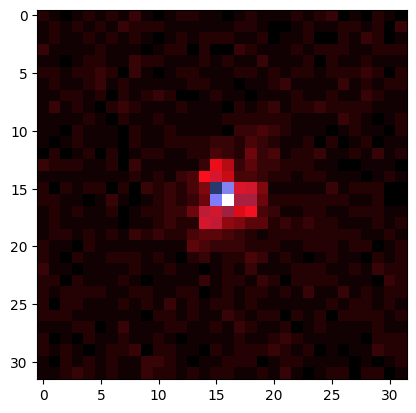

In [10]:
plt.imshow(noisy_test_stars[7], cmap='gist_stern')